In [6]:
import random
import numpy as np
import pandas as pd
from pathlib import Path

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm

# ─── Constants ────────────────────────────────────────────────────────────────
STEGO_CSV     = Path("csv/stego_final.csv")
IMAGES_DIR    = Path("Images")
BATCH_SIZE    = 64
EPOCHS        = 15
LR            = 2.5e-05
WEIGHT_DECAY  = 5e-04
RANDOM_SEED   = 42
NUM_CLASSES   = 2
BATCH_LOG_INT = 20
#DEVICE        = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
DEVICE="cpu"
# ─── 1) Load & Prepare DataFrame ───────────────────────────────────────────────
df_stego = pd.read_csv(STEGO_CSV)
df_stego = df_stego[df_stego.method.isin(["lsb","iwt"])].copy()
df_stego["binary_method"] = "stego"
df_stego["img_path"]      = df_stego["stego_path"]

n_stego    = len(df_stego)
all_images = list(IMAGES_DIR.glob("*"))
used_names = set(Path(p).name for p in df_stego["img_path"])
candidates = [str(p) for p in all_images if Path(p).name not in used_names]
none_samples = random.sample(candidates, min(n_stego, len(candidates)))

df_none = pd.DataFrame({
    "binary_method": ["none"] * len(none_samples),
    "img_path":      none_samples
})

df = pd.concat([
    df_stego[["binary_method","img_path"]],
    df_none
], ignore_index=True).sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

df["label"] = df["binary_method"].map({"none":0, "stego":1})

# ─── 2) Stratified splits ─────────────────────────────────────────────────────
df_train, df_test = train_test_split(
    df, test_size=0.30, stratify=df["label"], random_state=RANDOM_SEED
)
df_train, df_val  = train_test_split(
    df_train, test_size=0.30, stratify=df_train["label"], random_state=RANDOM_SEED
)

# ─── 3) Dataset + Transforms ───────────────────────────────────────────────────
class StegoDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.tf = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["img_path"]).convert("RGB")
        return self.tf(img), row["label"]

train_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
eval_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

train_ds = StegoDataset(df_train, train_tf)
val_ds   = StegoDataset(df_val,   eval_tf)
test_ds  = StegoDataset(df_test,  eval_tf)

# ─── 4) Weighted sampler upsamples “none” twice as often ───────────────────────
weights = np.where(df_train["label"]==0, 2.0, 1.0)
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                          sampler=sampler, num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=4)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=4)

# ─── 5) Build VGG‐16 specialist for “none” ─────────────────────────────────────
def build_vgg():
    m = models.vgg16(pretrained=True)
    in_f = m.classifier[6].in_features
    m.classifier[6] = nn.Linear(in_f, NUM_CLASSES)
    return m.to(DEVICE)

model_none = build_vgg()
criterion  = nn.CrossEntropyLoss()
optimizer  = Adam(model_none.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler  = StepLR(optimizer, step_size=7, gamma=0.1)




/home/nitinjha/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nitinjha/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
DEVICE        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─── 6) Train “none” specialist ───────────────────────────────────────────────
best_val_acc = 0.0
for epoch in range(1, EPOCHS+1):
    # train
    model_none.train()
    run_loss, run_corr = 0.0, 0
    for i,(imgs, labels) in enumerate(train_loader,1):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        out = model_none(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        run_loss += loss.item()*imgs.size(0)
        preds = out.argmax(1)
        run_corr += (preds==labels).sum().item()
        if i % BATCH_LOG_INT==0:
            print(f"[Train] Epoch {epoch}  Batch {i}/{len(train_loader)}  Loss {loss.item():.4f}")
    tloss = run_loss/len(train_loader.dataset)
    tacc  = run_corr/len(train_loader.dataset)
    # val
    model_none.eval()
    val_loss, val_corr = 0.0,0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            out = model_none(imgs)
            l  = criterion(out, labels)
            val_loss += l.item()*imgs.size(0)
            preds = out.argmax(1)
            val_corr += (preds==labels).sum().item()
    vloss = val_loss/len(val_loader.dataset)
    vacc  = val_corr/len(val_loader.dataset)
    scheduler.step()
    print(f"Epoch {epoch}/{EPOCHS}  Train Acc {tacc:.4f}  Val Acc {vacc:.4f}")
    if vacc>best_val_acc:
        best_val_acc=vacc
        torch.save(model_none.state_dict(),"best_vgg16_none.pth")



[Train] Epoch 1  Batch 20/59  Loss 0.6821
[Train] Epoch 1  Batch 40/59  Loss 0.5066
Epoch 1/20  Train Acc 0.7099  Val Acc 0.7315
[Train] Epoch 2  Batch 20/59  Loss 0.3963
[Train] Epoch 2  Batch 40/59  Loss 0.4687
Epoch 2/20  Train Acc 0.8100  Val Acc 0.7265
[Train] Epoch 3  Batch 20/59  Loss 0.2867
[Train] Epoch 3  Batch 40/59  Loss 0.3223
Epoch 3/20  Train Acc 0.8315  Val Acc 0.7202
[Train] Epoch 4  Batch 20/59  Loss 0.4010
[Train] Epoch 4  Batch 40/59  Loss 0.4559
Epoch 4/20  Train Acc 0.8095  Val Acc 0.7039
[Train] Epoch 5  Batch 20/59  Loss 0.3046
[Train] Epoch 5  Batch 40/59  Loss 0.2719
Epoch 5/20  Train Acc 0.8332  Val Acc 0.7252
[Train] Epoch 6  Batch 20/59  Loss 0.4351
[Train] Epoch 6  Batch 40/59  Loss 0.4936
Epoch 6/20  Train Acc 0.8520  Val Acc 0.7252
[Train] Epoch 7  Batch 20/59  Loss 0.3379
[Train] Epoch 7  Batch 40/59  Loss 0.3608
Epoch 7/20  Train Acc 0.8299  Val Acc 0.7189
[Train] Epoch 8  Batch 20/59  Loss 0.2855
[Train] Epoch 8  Batch 40/59  Loss 0.2569
Epoch 8/20  T

In [7]:
from tqdm import tqdm

# ─── Stego specialist training ────────────────────────────────────────────────

BATCH_SIZE    = 64
model_stego   = build_vgg()
optimizer_s   = Adam(model_stego.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler_s   = StepLR(optimizer_s, step_size=7, gamma=0.1)

# Upsample “stego” twice as often
weights_s     = np.where(df_train["label"]==1, 2.0, 1.0)
sampler_s     = WeightedRandomSampler(weights_s, num_samples=len(weights_s), replacement=True)
train_loader_s = DataLoader(train_ds, batch_size=BATCH_SIZE,
                            sampler=sampler_s, num_workers=4)

best_val_acc_s = 0.0

# Wrap epochs in tqdm
for epoch in tqdm(range(1, EPOCHS+1), desc="Epochs", unit="epoch"):
    # --- Train ---
    model_stego.train()
    run_loss, run_corr = 0.0, 0

    # Wrap batches in tqdm
    for imgs, labels in tqdm(train_loader_s, desc=f"Train Ep{epoch}", leave=False, unit="batch"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer_s.zero_grad()
        out = model_stego(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer_s.step()

        run_loss += loss.item() * imgs.size(0)
        run_corr += (out.argmax(1) == labels).sum().item()

    t_loss = run_loss / len(train_loader_s.dataset)
    t_acc  = run_corr / len(train_loader_s.dataset)

    # --- Validate ---
    model_stego.eval()
    val_loss, val_corr = 0.0, 0
    for imgs, labels in tqdm(val_loader, desc=f"Val Ep{epoch}", leave=False, unit="batch"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        out = model_stego(imgs)
        l   = criterion(out, labels)
        val_loss += l.item() * imgs.size(0)
        val_corr += (out.argmax(1) == labels).sum().item()

    v_loss = val_loss / len(val_loader.dataset)
    v_acc  = val_corr / len(val_loader.dataset)

    scheduler_s.step()

    # Summary print
    print(f"[Stego-Train] Epoch {epoch}/{EPOCHS}  "
          f"Train Loss {t_loss:.4f}, Acc {t_acc:.4f}  |  "
          f"Val Loss {v_loss:.4f}, Acc {v_acc:.4f}")

    # Save best
    if v_acc > best_val_acc_s:
        best_val_acc_s = v_acc
        torch.save(model_stego.state_dict(), "best_vgg16_stego.pth")
        print(f" → New best: {best_val_acc_s:.4f}")


Train Ep1: 100%|█████████████████████████████| 30/30 [04:19<00:00,  6.41s/batch]
                                                                                
Val Ep1: 100%|███████████████████████████████| 13/13 [00:37<00:00,  2.42s/batch]
                                                                                

[Stego-Train] Epoch 1/15  Train Loss 0.5728, Acc 0.6776  |  Val Loss 0.6945, Acc 0.5194


Epochs:   7%|██                            | 1/15 [04:57<1:09:18, 297.05s/epoch]

 → New best: 0.5194



Train Ep2: 100%|█████████████████████████████| 30/30 [04:20<00:00,  6.47s/batch]
                                                                                
Val Ep2: 100%|███████████████████████████████| 13/13 [00:38<00:00,  2.48s/batch]
                                                                                

[Stego-Train] Epoch 2/15  Train Loss 0.4717, Acc 0.7320  |  Val Loss 0.5657, Acc 0.6386


Epochs:  13%|████                          | 2/15 [09:56<1:04:43, 298.71s/epoch]

 → New best: 0.6386



Train Ep3: 100%|█████████████████████████████| 30/30 [04:27<00:00,  6.51s/batch]
                                                                                
Epochs:  20%|██████                        | 3/15 [15:02<1:00:24, 302.03s/epoch]

[Stego-Train] Epoch 3/15  Train Loss 0.4483, Acc 0.7368  |  Val Loss 0.6281, Acc 0.5684



Train Ep4: 100%|█████████████████████████████| 30/30 [04:22<00:00,  6.43s/batch]
                                                                                
Val Ep4: 100%|███████████████████████████████| 13/13 [00:38<00:00,  2.53s/batch]
                                                                                

[Stego-Train] Epoch 4/15  Train Loss 0.4299, Acc 0.7621  |  Val Loss 0.6077, Acc 0.6524


Epochs:  27%|████████▌                       | 4/15 [20:05<55:25, 302.31s/epoch]

 → New best: 0.6524



Train Ep5: 100%|█████████████████████████████| 30/30 [04:25<00:00,  6.52s/batch]
                                                                                
Epochs:  33%|██████████▋                     | 5/15 [25:10<50:30, 303.06s/epoch]

[Stego-Train] Epoch 5/15  Train Loss 0.4058, Acc 0.7815  |  Val Loss 0.7646, Acc 0.5671



Train Ep6: 100%|█████████████████████████████| 30/30 [04:25<00:00,  6.45s/batch]
                                                                                
Epochs:  40%|████████████▊                   | 6/15 [30:15<45:34, 303.86s/epoch]

[Stego-Train] Epoch 6/15  Train Loss 0.3846, Acc 0.8041  |  Val Loss 0.6455, Acc 0.6186



Train Ep7: 100%|█████████████████████████████| 30/30 [04:22<00:00,  6.44s/batch]
                                                                                
Epochs:  47%|██████████████▉                 | 7/15 [35:16<40:24, 303.02s/epoch]

[Stego-Train] Epoch 7/15  Train Loss 0.3850, Acc 0.7917  |  Val Loss 0.7216, Acc 0.5897



Train Ep8: 100%|█████████████████████████████| 30/30 [04:22<00:00,  6.46s/batch]
                                                                                
Epochs:  53%|█████████████████               | 8/15 [40:18<35:17, 302.53s/epoch]

[Stego-Train] Epoch 8/15  Train Loss 0.3679, Acc 0.8041  |  Val Loss 0.6739, Acc 0.6048



Train Ep9: 100%|█████████████████████████████| 30/30 [04:16<00:00,  6.32s/batch]
                                                                                
Epochs:  60%|███████████████████▏            | 9/15 [45:13<30:01, 300.26s/epoch]

[Stego-Train] Epoch 9/15  Train Loss 0.3531, Acc 0.8208  |  Val Loss 0.6921, Acc 0.6148



Train Ep10: 100%|████████████████████████████| 30/30 [04:23<00:00,  6.45s/batch]
                                                                                
Epochs:  67%|████████████████████▋          | 10/15 [50:15<25:04, 300.91s/epoch]

[Stego-Train] Epoch 10/15  Train Loss 0.3573, Acc 0.8159  |  Val Loss 0.7044, Acc 0.6261



Train Ep11: 100%|████████████████████████████| 30/30 [04:55<00:00,  7.86s/batch]
                                                                                
Epochs:  73%|██████████████████████▋        | 11/15 [56:01<20:57, 314.45s/epoch]

[Stego-Train] Epoch 11/15  Train Loss 0.3411, Acc 0.8240  |  Val Loss 0.7174, Acc 0.6198



Train Ep12: 100%|████████████████████████████| 30/30 [04:37<00:00,  6.52s/batch]
                                                                                
Epochs:  80%|███████████████████████▏     | 12/15 [1:01:17<15:45, 315.01s/epoch]

[Stego-Train] Epoch 12/15  Train Loss 0.3356, Acc 0.8337  |  Val Loss 0.7526, Acc 0.6073



Train Ep13: 100%|████████████████████████████| 30/30 [04:21<00:00,  6.41s/batch]
                                                                                
Epochs:  87%|█████████████████████████▏   | 13/15 [1:06:17<10:21, 310.61s/epoch]

[Stego-Train] Epoch 13/15  Train Loss 0.3472, Acc 0.8235  |  Val Loss 0.7491, Acc 0.6186



Train Ep14: 100%|████████████████████████████| 30/30 [04:22<00:00,  6.46s/batch]
                                                                                
Epochs:  93%|███████████████████████████  | 14/15 [1:11:19<05:07, 307.91s/epoch]

[Stego-Train] Epoch 14/15  Train Loss 0.3519, Acc 0.8122  |  Val Loss 0.7556, Acc 0.6110



Train Ep15: 100%|████████████████████████████| 30/30 [04:21<00:00,  6.38s/batch]
                                                                                
Epochs: 100%|█████████████████████████████| 15/15 [1:16:19<00:00, 305.28s/epoch]

[Stego-Train] Epoch 15/15  Train Loss 0.3236, Acc 0.8364  |  Val Loss 0.7568, Acc 0.6123



Ensemble Accuracy (VGG): 0.6594

              precision    recall  f1-score   support

        none     0.6487    0.6965    0.6717       570
       stego     0.6717    0.6221    0.6460       569

    accuracy                         0.6594      1139
   macro avg     0.6602    0.6593    0.6589      1139
weighted avg     0.6602    0.6594    0.6589      1139



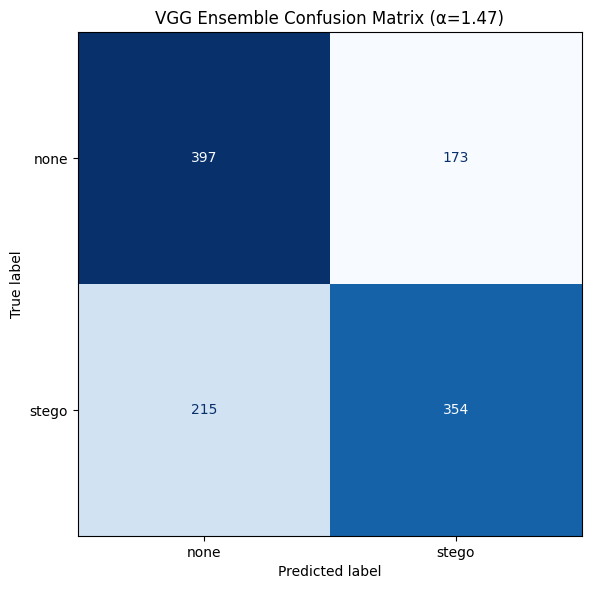

In [8]:
# ─── 8) Load both specialists & run weighted‐ensemble ─────────────────────────
model_stego = build_vgg()
model_stego.load_state_dict(torch.load("best_vgg16_stego.pth", map_location=DEVICE))
model_none.load_state_dict(torch.load("best_vgg16_none.pth", map_location=DEVICE))
model_stego.eval()
model_none.eval()
softmax = nn.Softmax(dim=1)

ensemble_preds, true_labels = [], []
alpha = 1.47  # your optimized weight

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        out_s = model_stego(imgs)
        out_n = model_none(imgs)
        conf_s = softmax(out_s)[:,1]
        conf_n = softmax(out_n)[:,0]
        preds = torch.where(conf_s*alpha>conf_n, 1, 0)
        ensemble_preds.extend(preds.cpu().numpy())
        true_labels.extend(labels.numpy())

ensemble_preds = np.array(ensemble_preds)
true_labels    = np.array(true_labels)

# ─── 9) Report & Plot ─────────────────────────────────────────────────────────
acc = (ensemble_preds==true_labels).mean()
print(f"\nEnsemble Accuracy (VGG): {acc:.4f}\n")
print(classification_report(true_labels, ensemble_preds,
                            target_names=["none","stego"], digits=4))

cm = confusion_matrix(true_labels, ensemble_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["none","stego"])
fig, ax = plt.subplots(1,1,figsize=(6,6))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title(f"VGG Ensemble Confusion Matrix (α={alpha})")
plt.tight_layout()
plt.show()


Ensemble Accuracy (VGG): 0.6488

              precision    recall  f1-score   support

        none     0.6446    0.6649    0.6546       570
       stego     0.6534    0.6327    0.6429       569

    accuracy                         0.6488      1139
   macro avg     0.6490    0.6488    0.6487      1139
weighted avg     0.6490    0.6488    0.6487      1139



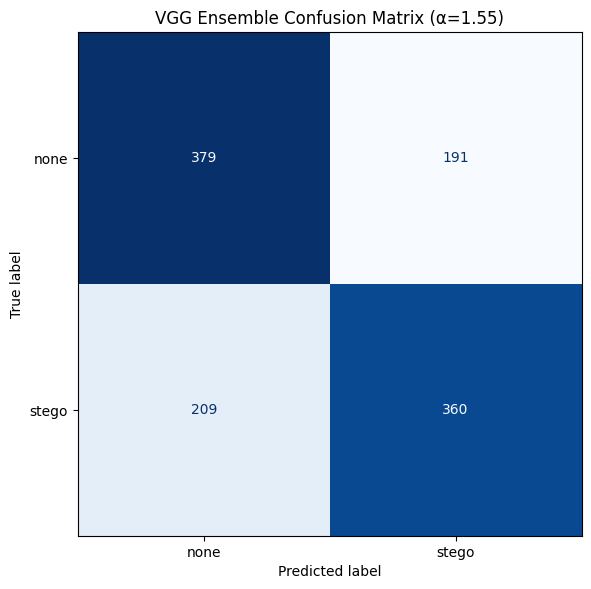

In [9]:

ensemble_preds, true_labels = [], []
alpha = 1.55  # your optimized weight

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        out_s = model_stego(imgs)
        out_n = model_none(imgs)
        conf_s = softmax(out_s)[:,1]
        conf_n = softmax(out_n)[:,0]
        preds = torch.where(conf_s*alpha>conf_n, 1, 0)
        ensemble_preds.extend(preds.cpu().numpy())
        true_labels.extend(labels.numpy())

ensemble_preds = np.array(ensemble_preds)
true_labels    = np.array(true_labels)

# ─── 9) Report & Plot ─────────────────────────────────────────────────────────
acc = (ensemble_preds==true_labels).mean()
print(f"\nEnsemble Accuracy (VGG): {acc:.4f}\n")
print(classification_report(true_labels, ensemble_preds,
                            target_names=["none","stego"], digits=4))

cm = confusion_matrix(true_labels, ensemble_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["none","stego"])
fig, ax = plt.subplots(1,1,figsize=(6,6))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title(f"VGG Ensemble Confusion Matrix (α={alpha})")
plt.tight_layout()
plt.show()